## Set up

In [ ]:
!pip install -q transformers

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l1, l2



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
home_dir = Path('/content/drive/MyDrive/266 Final Project/Code')
train_path = home_dir / 'data' / 'train'
val_path = home_dir / 'data' / 'val'
test_path = home_dir / 'data' / 'test'

In [ ]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
results = {}

for category in (['em', 'in', 'ex', 'ex_aug']):
    X_train = pd.read_csv(train_path / f'X_{category}.csv', delimiter=',')
    # X_train = X_train['response_post']

    results[f'{category}_seeker_wordcount'] = X_train['seeker_post'].str.split().apply(len).describe()
    results[f'{category}_seeker_token_count'] = X_train['seeker_post'].apply(lambda x: len(bert_tokenizer.tokenize(x))).describe()
    results[f'{category}_response_wordcount'] = X_train['response_post'].str.split().apply(len).describe()
    results[f'{category}_response_token_count'] = X_train['response_post'].apply(lambda x: len(bert_tokenizer.tokenize(x))).describe()
    mask = (X_train['longest_rationale'].notnull())
    longest_rationale = X_train.loc[mask, 'longest_rationale']

    results[f'{category}_longest_rationale_wordcount'] = longest_rationale.str.split().apply(len).describe()
    results[f'{category}_longest_rationale_token_count'] = longest_rationale.apply(lambda x: len(bert_tokenizer.tokenize(x))).describe()
    # results[f'{category}_seeker_wordcount'] = X_train['seeker_post'].str.split().apply(len).describe()
    # results[f'{category}_seeker_token_count'] = X_train['seeker_post'].apply(lambda x: len(bert_tokenizer.tokenize(x))).describe()


summary_table = pd.DataFrame(results)

summary_table = summary_table.transpose()

summary_table



,count,mean,std,min,25%,50%,75%,max
em_seeker_wordcount,1256.0,35.428344,26.695890,7.0,18.0,30.5,46.00,208.0
em_seeker_token_count,1256.0,45.429140,33.169944,8.0,24.0,39.0,57.25,272.0
em_response_wordcount,1256.0,48.544586,73.467111,5.0,14.0,29.0,59.00,1811.0
em_response_token_count,1256.0,60.586783,89.234811,5.0,19.0,36.0,73.00,2163.0
em_longest_rationale_wordcount,626.0,15.552716,15.432058,1.0,6.0,11.0,20.00,184.0
em_longest_rationale_token_count,626.0,19.602236,18.966664,1.0,8.0,14.0,25.00,216.0
in_seeker_wordcount,1850.0,34.620000,25.158684,6.0,18.0,30.0,45.00,216.0
in_seeker_token_count,1850.0,44.554595,31.024624,8.0,24.0,38.5,57.00,272.0
in_response_wordcount,1850.0,47.835676,69.720736,5.0,14.0,28.0,58.00,1811.0
in_response_token_count,1850.0,59.848649,85.144879,5.0,18.0,35.0,72.00,2163.0


In [ ]:
FEATURES = 'response_post'
rationale='longest_rationale'
MAX_LENGTH=150

em_response_token_count = 150
in_response_token_count = 145
ex_response_token_count = 106
ex_aug_response_token_count = 122

em_rationale_token_count = 14
in_rationale_token_count = 32
ex_rationale_token_count = 9
ex_aug_rationale_token_count = 9

In [ ]:
def get_token_count(rat):
    if (type(rat) != float) & (type(rat) != None):
        return len(bert_tokenizer.tokenize(rat))
    return None
category='ex_aug'
X_test = pd.read_csv(test_path / f'X_{category}.csv', delimiter=',')
y_test = pd.read_csv((test_path / f'y_{category}.csv'), delimiter=',')
y_test = y_test['empathy']
X_test['y'] = y_test
# mask = (X_test['longest_rationale'].notnull())
X_test['longest_rationale_token_count'] = X_test['longest_rationale'].apply(lambda x: get_token_count(x))
# longest_rationale.apply(lambda x: len(bert_tokenizer.tokenize(x)))
# X_test['longest_rationale_token_count'].describe()

In [ ]:
ex_aug_rationale_token_count = X_test[X_test['longest_rationale_token_count'].notnull()]['longest_rationale_token_count'].describe()['50%']

In [ ]:
X_test_short, X_test_long = train_test_split(X_test[X_test['longest_rationale'].isnull()], test_size=0.5, random_state=42)
X_test_short = pd.concat([X_test_short, X_test[X_test['longest_rationale_token_count'] < ex_aug_rationale_token_count]], axis=0)
X_test_long = pd.concat([X_test_long, X_test[X_test['longest_rationale_token_count'] >= ex_aug_rationale_token_count]], axis=0)


In [ ]:
rationale = 'longest_rationale'
mask = (X_test_short[rationale].notnull()) & (X_test_short['y']==1)
X_test_short.loc[mask, "response_post"] = X_test_short.loc[mask, rationale]

In [ ]:
X_test_short

,seeker_post,response_post,augmented_flag,rationales,first_rationale,longest_rationale,y,longest_rationale_token_count
157,Does anyone else get really anxious/paranoid t...,No because I know it's a fact I'm unlikable,0,NaN,NaN,NaN,0,NaN
152,I cannot sleep!. Please why can't my brain jus...,"It's only about 1:45, there's still time to ge...",0,NaN,NaN,NaN,0,NaN
161,Called into work because of depression (rant)....,"Well, get up, have a shower and do something p...",0,NaN,NaN,NaN,0,NaN
75,Going to buy a little buddy. I really want to ...,Any pet will really help. Just something to ke...,0,NaN,NaN,NaN,0,NaN
198,I need to get out right now.. I can't take it....,"I had some major shit go on 2 years ago, mothe...",0,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...
287,"I don’t want to die, I just want to stop exist...",Only sometimes?,1,Only sometimes?|,Only sometimes?,Only sometimes?,1,3.0
297,My friends started to hang out without me and ...,are you quiet or shy?,0,are you quiet or shy?|,are you quiet or shy?,are you quiet or shy?,1,6.0
308,Without music i wouldve killed myself. Listing...,Do you mind sharing your playlist?,0,Do you mind sharing your playlist?|,Do you mind sharing your playlist?,Do you mind sharing your playlist?,1,8.0
313,"I gave up. I keep making the same mistakes, so...",whats happened anyway,0,whats happened anyway|,whats happened anyway,whats happened anyway,1,4.0


In [ ]:
# get data and replace response with rationale in rows where y=1
# don't replace if there is no rationale

def get_token_count(rat):
    if (type(rat) != float) & (type(rat) != None):
        return len(bert_tokenizer.tokenize(rat))
    return None

def get_data(category, rationale=rationale):
    y_train = pd.read_csv((train_path / f'y_{category}.csv'), delimiter=',')
    y_val = pd.read_csv((val_path / f'y_{category}.csv'), delimiter=',')
    y_test = pd.read_csv((test_path / f'y_{category}.csv'), delimiter=',')

    y_train = y_train['empathy']
    y_val = y_val['empathy']
    y_test = y_test['empathy']

    X_train = pd.read_csv(train_path / f'X_{category}.csv', delimiter=',')
    X_val = pd.read_csv(val_path / f'X_{category}.csv', delimiter=',')
    X_test = pd.read_csv(test_path / f'X_{category}.csv', delimiter=',')

    X_train['y'] = y_train
    mask = (X_train['longest_rationale'].notnull()) & (X_train['y']==1)
    X_train.loc[mask, "response_post"] = X_train.loc[mask, 'longest_rationale']
    X_train = X_train['response_post']

    X_val['y'] = y_val
    mask = (X_val['longest_rationale'].notnull()) & (X_val['y']==1)
    X_val.loc[mask, "response_post"] = X_val.loc[mask, 'longest_rationale']
    X_val = X_val['response_post']

    X_test['y'] = y_test
    # mask = (X_test['longest_rationale'].notnull())
    X_test['longest_rationale_token_count'] = X_test['longest_rationale'].apply(lambda x: get_token_count(x))
    rationale_token_count = X_test[X_test['longest_rationale_token_count'].notnull()]['longest_rationale_token_count'].describe()['50%']
    X_test_short, X_test_long = train_test_split(X_test[X_test['longest_rationale'].isnull()], test_size=0.5, random_state=42)
    X_test_short = pd.concat([X_test_short, X_test[X_test['longest_rationale_token_count'] < rationale_token_count]], axis=0)
    X_test_long = pd.concat([X_test_long, X_test[X_test['longest_rationale_token_count'] >= rationale_token_count]], axis=0)

    mask = (X_test_short['longest_rationale'].notnull()) & (X_test_short['y']==1)
    X_test_short.loc[mask, "response_post"] = X_test_short.loc[mask, 'longest_rationale']

    mask = (X_test_long['longest_rationale'].notnull()) & (X_test_long['y']==1)
    X_test_long.loc[mask, "response_post"] = X_test_long.loc[mask, 'longest_rationale']

    y_test_short = X_test_short['y']
    y_test_long = X_test_long['y']
    X_test_short = X_test_short['response_post']
    X_test_long = X_test_long['response_post']

    return y_train, y_val, y_test_short, y_test_long, X_train, X_val, X_test_short, X_test_long


#no manual adjustment of token_type_ids; everything will be 0
def csv_to_encodings(X_train, X_val, X_test_short, X_test_long, max_length=MAX_LENGTH):
    #chunk and pad seeker_post, then add [SEP] to join with response_post

    # X_train = pd.read_csv(train_path / f'X_{category}.csv', delimiter=',')
    # X_train = X_train[features]
    # X_train_combined = X_train.apply(prepare_text, axis=1)
    train_em_encodings = bert_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

    # X_val = pd.read_csv(val_path / f'X_{category}.csv', delimiter=',')
    # X_val = X_val[features]
    # X_val_combined = X_val.apply(prepare_text, axis=1)
    val_em_encodings = bert_tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

    # X_test = pd.read_csv(test_path / f'X_{category}.csv', delimiter=',')
    # X_test = X_test[features]
    # X_test_combined = X_test.apply(prepare_text, axis=1)
    test_short_em_encodings = bert_tokenizer(X_test_short.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
    test_long_em_encodings = bert_tokenizer(X_test_long.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

    return train_em_encodings, val_em_encodings, test_short_em_encodings, test_long_em_encodings

### chunking considerations

## Models

In [ ]:
def create_bert_binary_model(bert_model,max_length = MAX_LENGTH,
                                 hidden_size = 100,
                                 dropout=0.3,
                                 learning_rate=0.0003):


    bert_model.trainable = False #not fine tuning BERT embeddings

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(),
                                 metrics='accuracy')



    return classification_model

In [ ]:
def run_model(category):
    y_train, y_val, y_test_short, y_test_long, X_train, X_val, X_test_short, X_test_long = get_data(category)

    print(f'y_train value counts:\n{y_train.value_counts()}')

    train_encodings, val_encodings, test_encodings_short, test_encodings_long = csv_to_encodings(X_train, X_val, X_test_short, X_test_long)
    print(f'train_encodings:\n{train_encodings}')

    classification = create_bert_binary_model(bert_model=bert_model)
    classification_history = classification.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight
                                                  )

    metrics_columns = ['Category', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

    # short predictions:
    predictions_short = classification.predict([test_encodings_short.input_ids, test_encodings_short.token_type_ids, test_encodings_short.attention_mask])
    predictions_short = (predictions_short >= 0.5).astype(int)


    accuracy_short = accuracy_score(y_test_short, predictions_short)
    print(f"accuracy for test: {accuracy_short}")
    recall_short = recall_score(y_test_short, predictions_short)
    print(f"recall for test: {recall_short}")
    precision_short = precision_score(y_test_short, predictions_short)
    print(f"precision for test: {precision_short}")
    f1_short = f1_score(y_test_short, predictions_short)
    print(f"f1 score for test: {f1_short}")

    conf_matrix_short = confusion_matrix(y_test_short, predictions_short)
    print(conf_matrix_short)

    sns.set(font_scale=1.2)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_short, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{category} Confusion Matrix - short')
    plt.show()


    metrics_short = {
        'Category': f'{category}-short',
        'Accuracy': accuracy_short,
        'Precision': precision_short,
        'Recall': recall_short,
        'F1 Score': f1_short
    }
    metrics_short = pd.DataFrame([metrics_short], columns=metrics_columns)

    # long predictions:
    predictions_long = classification.predict([test_encodings_long.input_ids, test_encodings_long.token_type_ids, test_encodings_long.attention_mask])
    predictions_long = (predictions_long >= 0.5).astype(int)

    accuracy_long = accuracy_score(y_test_long, predictions_long)
    print(f"accuracy for test: {accuracy_long}")
    recall_long = recall_score(y_test_long, predictions_long)
    print(f"recall for test: {recall_long}")
    precision_long = precision_score(y_test_long, predictions_long)
    print(f"precision for test: {precision_long}")
    f1_long = f1_score(y_test_long, predictions_long)
    print(f"f1 score for test: {f1_long}")

    conf_matrix_long = confusion_matrix(y_test_long, predictions_long)
    print(conf_matrix_long)

    sns.set(font_scale=1.2)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_long, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{category} Confusion Matrix - long')
    plt.show()

    metrics_long = {
        'Category': f'{category}-long',
        'Accuracy': accuracy_long,
        'Precision': precision_long,
        'Recall': recall_long,
        'F1 Score': f1_long
    }
    metrics_long = pd.DataFrame([metrics_long], columns=metrics_columns)

    return metrics_short, metrics_long


## Run Models

y_train value counts:
0    629
1    627
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(1256, 150), dtype=int32, numpy=
array([[  101,   146,   112, ...,     0,     0,     0],
       [  101,   146,  1221, ...,     0,     0,     0],
       [  101,  1109,  2501, ...,     0,     0,     0],
       ...,
       [  101, 13280,  2959, ...,     0,     0,     0],
       [  101,  1128,  9424, ...,     0,     0,     0],
       [  101,  1337,  1122, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1256, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1256, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ...

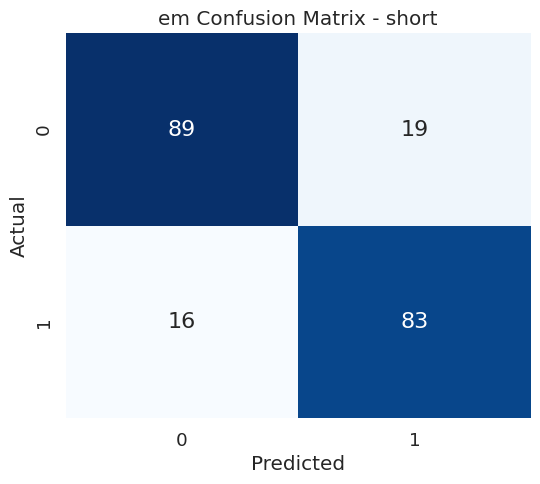

7/7 [==============================] - 2s 314ms/step
accuracy for test: 0.8632075471698113
recall for test: 0.803921568627451
precision for test: 0.9010989010989011
f1 score for test: 0.8497409326424871
[[101   9]
 [ 20  82]]


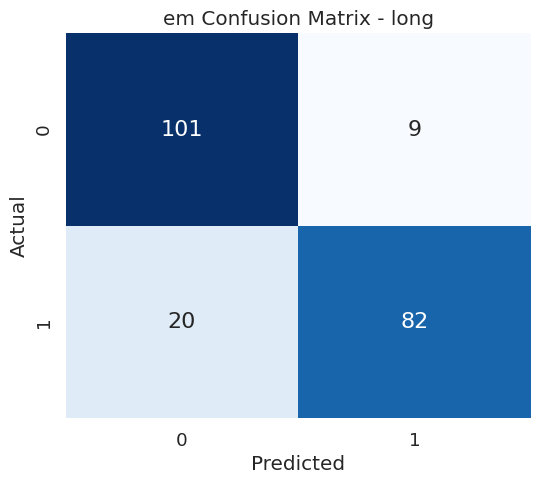

In [ ]:
em_metrics_short, em_metrics_long = run_model('em')

y_train value counts:
0    972
1    878
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(1850, 150), dtype=int32, numpy=
array([[  101,  2140,   117, ...,     0,     0,     0],
       [  101,  4373,  1128, ...,     0,     0,     0],
       [  101,   168,  7595, ...,  1821,  1643,   102],
       ...,
       [  101, 14060,   119, ...,     0,     0,     0],
       [  101,  1284,   112, ...,     0,     0,     0],
       [  101,  1370,  1143, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1850, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1850, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ...

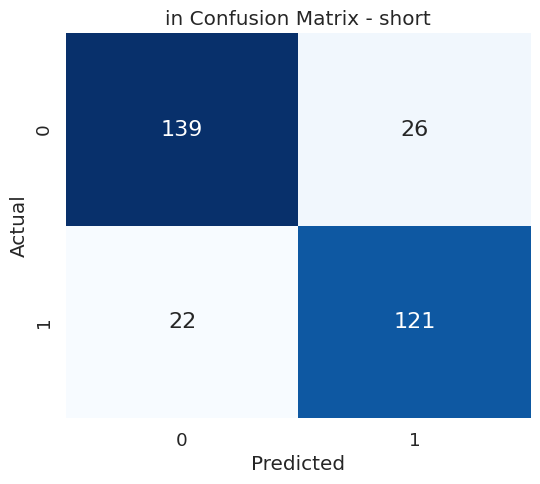

10/10 [==============================] - 3s 324ms/step
accuracy for test: 0.86084142394822
recall for test: 0.9300699300699301
precision for test: 0.8012048192771084
f1 score for test: 0.86084142394822
[[133  33]
 [ 10 133]]


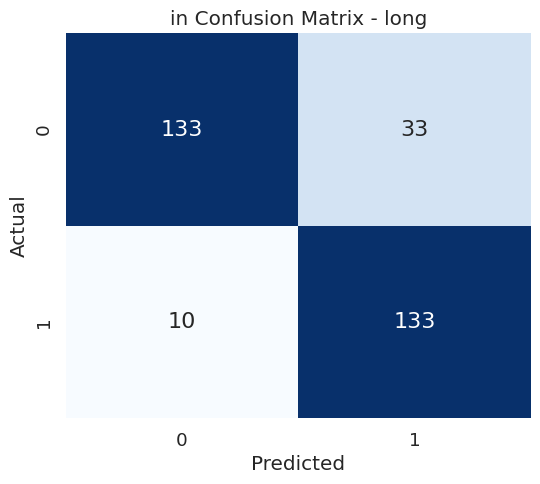

In [ ]:
in_metrics_short, in_metrics_long = run_model('in')

y_train value counts:
1    294
0    282
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(576, 150), dtype=int32, numpy=
array([[ 101,  146, 3668, ...,    0,    0,    0],
       [ 101, 1302, 1274, ...,    0,    0,    0],
       [ 101, 7595,  117, ...,    0,    0,    0],
       ...,
       [ 101, 1132, 1128, ...,    0,    0,    0],
       [ 101, 1135, 1281, ...,    0,    0,    0],
       [ 101, 8790, 1910, ..., 9655,  119,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(576, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(576, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0,

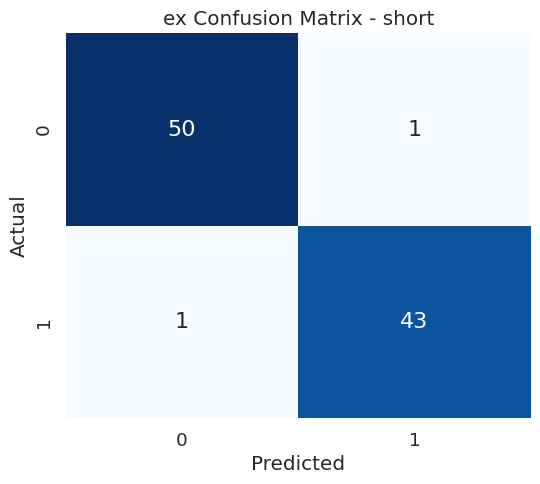

4/4 [==============================] - 1s 244ms/step
accuracy for test: 0.9896907216494846
recall for test: 0.9787234042553191
precision for test: 1.0
f1 score for test: 0.989247311827957
[[50  0]
 [ 1 46]]


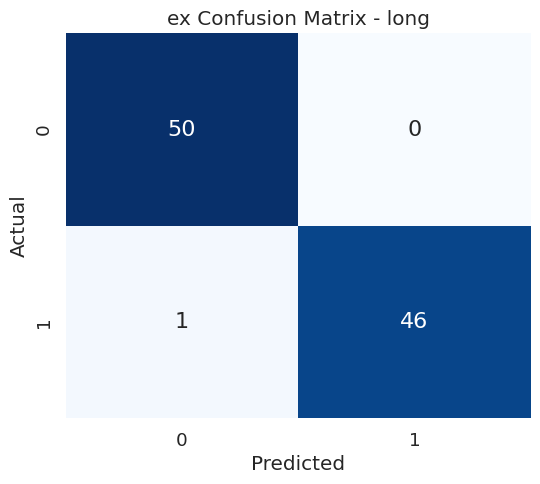

In [ ]:
ex_metrics_short, ex_metrics_long = run_model('ex')

y_train value counts:
1    498
0    486
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[ 101, 1327, 2228, ...,    0,    0,    0],
       [ 101, 8790,  106, ...,    0,    0,    0],
       [ 101, 1188, 2304, ...,    0,    0,    0],
       ...,
       [ 101, 1731, 1209, ...,    0,    0,    0],
       [ 101, 1327, 1164, ...,    0,    0,    0],
       [ 101, 2825, 1128, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0,

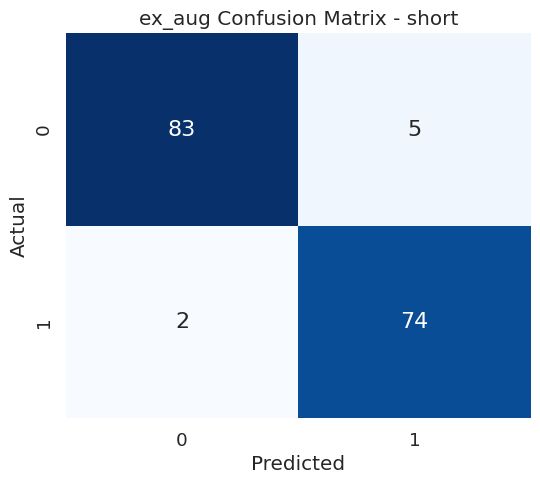

6/6 [==============================] - 2s 277ms/step
accuracy for test: 0.975609756097561
recall for test: 0.9605263157894737
precision for test: 0.9864864864864865
f1 score for test: 0.9733333333333333
[[87  1]
 [ 3 73]]


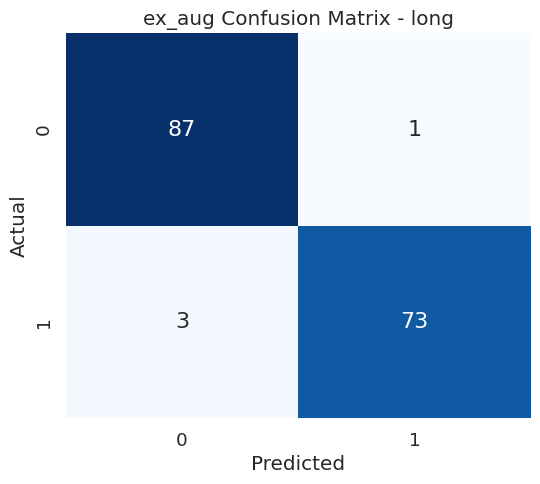

In [ ]:
ex_aug_metrics_short, ex_aug_metrics_long = run_model('ex_aug')

In [ ]:
metrics = pd.concat([em_metrics_short, em_metrics_long, in_metrics_short, in_metrics_long, ex_metrics_short, ex_metrics_long, ex_aug_metrics_short, ex_aug_metrics_long], ignore_index=True)
display(metrics)

,Category,Accuracy,Precision,Recall,F1 Score
0,em-short,0.830918,0.813725,0.838384,0.825871
1,em-long,0.863208,0.901099,0.803922,0.849741
2,in-short,0.844156,0.823129,0.846154,0.834483
3,in-long,0.860841,0.801205,0.930070,0.860841
4,ex-short,0.978947,0.977273,0.977273,0.977273
5,ex-long,0.989691,1.000000,0.978723,0.989247
6,ex_aug-short,0.957317,0.936709,0.973684,0.954839
7,ex_aug-long,0.975610,0.986486,0.960526,0.973333


In [ ]:
metrics_short = pd.concat([em_metrics_short, in_metrics_short, ex_metrics_short, ex_aug_metrics_short], ignore_index=True)
print('Metrics for Short Rationale Replacement')
display(metrics_short)

Metrics for Short Rationale Replacement


,Category,Accuracy,Precision,Recall,F1 Score
0,em-short,0.830918,0.813725,0.838384,0.825871
1,in-short,0.844156,0.823129,0.846154,0.834483
2,ex-short,0.978947,0.977273,0.977273,0.977273
3,ex_aug-short,0.957317,0.936709,0.973684,0.954839


In [ ]:
metrics_long = pd.concat([em_metrics_long, in_metrics_long, ex_metrics_long, ex_aug_metrics_long], ignore_index=True)
print('Metrics for Long Rationale Replacement')
display(metrics_long)

Metrics for Long Rationale Replacement


,Category,Accuracy,Precision,Recall,F1 Score
0,em-long,0.863208,0.901099,0.803922,0.849741
1,in-long,0.860841,0.801205,0.930070,0.860841
2,ex-long,0.989691,1.000000,0.978723,0.989247
3,ex_aug-long,0.975610,0.986486,0.960526,0.973333


# %%%%%%%%%%%%%%%%% GRAVEYARD %%%%%%%%%%%%%%%%

In [ ]:
y_em_train, y_em_val, y_em_test_short, y_em_test_long, X_em_train, X_em_val, X_em_test_short, X_em_test_long = get_data('em')
y_em_train.value_counts()

0    629
1    627
Name: empathy, dtype: int64

In [ ]:
train_em_encodings, val_em_encodings, test_em_short_encodings, test_em_long_encodings = csv_to_encodings(X_em_train, X_em_val, X_em_test_short, X_em_test_long)
train_em_encodings

{'input_ids': <tf.Tensor: shape=(1256, 150), dtype=int32, numpy=
array([[  101,   146,   112, ...,     0,     0,     0],
       [  101,   146,  1221, ...,     0,     0,     0],
       [  101,  1109,  2501, ...,     0,     0,     0],
       ...,
       [  101, 13280,  2959, ...,     0,     0,     0],
       [  101,  1128,  9424, ...,     0,     0,     0],
       [  101,  1337,  1122, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1256, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1256, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [ ]:
em_classification = create_bert_binary_model(bert_model=bert_model)
em_classification_history = em_classification.fit([train_em_encodings.input_ids, train_em_encodings.token_type_ids, train_em_encodings.attention_mask],
                                                  y_em_train,
                                                  validation_data=([val_em_encodings.input_ids, val_em_encodings.token_type_ids, val_em_encodings.attention_mask],
                                                  y_em_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
157/157 [==============================] - 33s 138ms/step - loss: 0.5412 - accuracy: 0.7062 - val_loss: 0.4010 - val_accuracy: 0.8282
Epoch 2/10
157/157 [==============================] - 19s 121ms/step - loss: 0.3876 - accuracy: 0.8304 - val_loss: 0.3523 - val_accuracy: 0.8473
Epoch 3/10
157/157 [==============================] - 25s 157ms/step - loss: 0.3673 - accuracy: 0.8304 - val_loss: 0.3617 - val_accuracy: 0.8377
Epoch 4/10
157/157 [==============================] - 19s 122ms/step - loss: 0.3383 - accuracy: 0.8432 - val_loss: 0.3277 - val_accuracy: 0.8544
Epoch 5/10
157/157 [==============================] - 19s 123ms/step - loss: 0.3322 - accuracy: 0.8471 - val_loss: 0.3193 - val_accuracy: 0.8592
Epoch 6/10
157/157 [==============================] - 24s 155ms/step - loss: 0.3272 - accuracy: 0.8439 - val_loss: 0.3307 - val_accuracy: 0.8425
Epoch 7/10
157/157 [==============================] - 19s 123ms/step - loss: 0.3306 - accuracy: 0.8559 - val_loss: 0.3094 - val_ac

##EM Short

In [ ]:
predictions_em_short = em_classification.predict([test_em_short_encodings.input_ids, test_em_short_encodings.token_type_ids, test_em_short_encodings.attention_mask])
# predictions_em_short = (predictions_em_short >= 0.5).astype(int)

7/7 [==============================] - 2s 309ms/step


In [ ]:
accuracy_em_short = accuracy_score(y_em_test_short, predictions_em_short)
print(f"accuracy for test: {accuracy_em_short}")
recall_em_short = recall_score(y_em_test_short, predictions_em_short)
print(f"recall for test: {recall_em_short}")
precision_em_short = precision_score(y_em_test_short, predictions_em_short)
print(f"precision for test: {precision_em_short}")
f1_em_short = f1_score(y_em_test_short, predictions_em_short)
print(f"f1 score for test: {f1_em_short}")

accuracy for test: 0.8309178743961353
recall for test: 0.8181818181818182
precision for test: 0.826530612244898
f1 score for test: 0.8223350253807107


[[91 17]
 [18 81]]


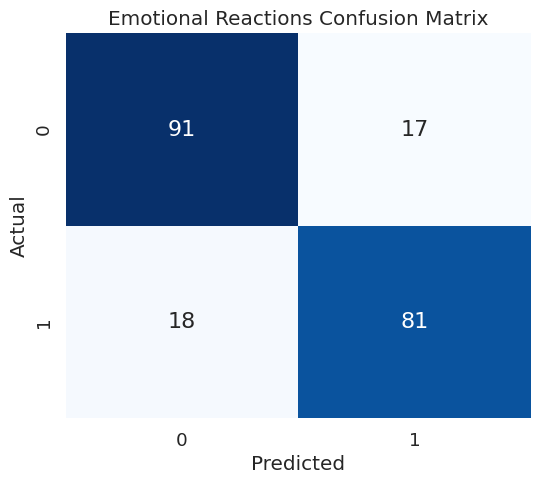

In [ ]:
conf_matrix_em_short = confusion_matrix(y_em_test_short, predictions_em_short)
print(conf_matrix_em_short)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_em_short, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Emotional Reactions Confusion Matrix')
plt.show()

##EM Long

In [ ]:
predictions_em_long = em_classification.predict([test_em_long_encodings.input_ids, test_em_long_encodings.token_type_ids, test_em_long_encodings.attention_mask])
predictions_em_long = (predictions_em_long >= 0.5).astype(int)

7/7 [==============================] - 2s 316ms/step


In [ ]:
accuracy_em_long = accuracy_score(y_em_test_long, predictions_em_long)
print(f"accuracy for test: {accuracy_em_long}")
recall_em_long = recall_score(y_em_test_long, predictions_em_long)
print(f"recall for test: {recall_em_long}")
precision_em_long = precision_score(y_em_test_long, predictions_em_long)
print(f"precision for test: {precision_em_short}")
f1_em_long = f1_score(y_em_test_long, predictions_em_long)
print(f"f1 score for test: {f1_em_long}")

accuracy for test: 0.839622641509434
recall for test: 0.7647058823529411
precision for test: 0.826530612244898
f1 score for test: 0.8210526315789474


[[100  10]
 [ 24  78]]


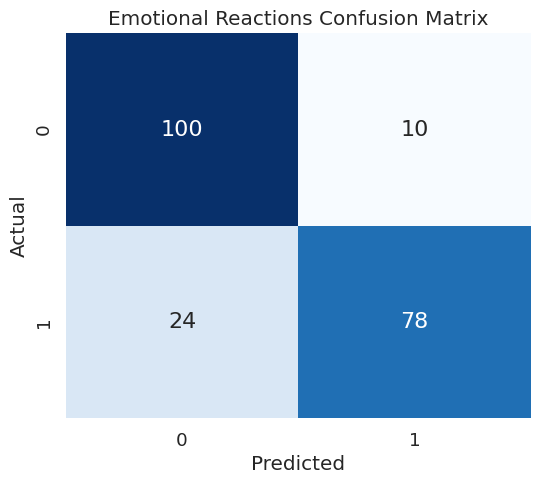

In [ ]:
conf_matrix_em_long = confusion_matrix(y_em_test_long, predictions_em_long)
print(conf_matrix_em_long)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_em_long, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Emotional Reactions Confusion Matrix')
plt.show()

# IN binary prediction

In [ ]:
y_in_train, y_in_val, y_in_test_short, y_in_test_long, X_in_train, X_in_val, X_in_test_short, X_in_test_long = get_data('in')
y_in_train.value_counts()

0    972
1    878
Name: empathy, dtype: int64

In [ ]:
train_in_encodings, val_in_encodings, test_in_encodings = csv_to_encodings(X_in_train, X_in_val, X_in_test)
train_in_encodings

{'input_ids': <tf.Tensor: shape=(1850, 61), dtype=int32, numpy=
array([[  101,  2140,   117, ...,  1107,  1103,   102],
       [  101,  4373,  1128, ...,     0,     0,     0],
       [  101,   168,  7595, ...,   111,  1821,   102],
       ...,
       [  101, 14060,   119, ...,  2277,   119,   102],
       [  101,  1284,   112, ...,     0,     0,     0],
       [  101, 10560,  1176, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1850, 61), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1850, 61), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [ ]:
in_classification = create_bert_binary_model(bert_model=bert_model)
in_classification_history = in_classification.fit([train_in_encodings.input_ids, train_in_encodings.token_type_ids, train_in_encodings.attention_mask],
                                                  y_in_train,
                                                  validation_data=([val_in_encodings.input_ids, val_in_encodings.token_type_ids, val_in_encodings.attention_mask],
                                                  y_in_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
232/232 [==============================] - 34s 91ms/step - loss: 0.3656 - accuracy: 0.8319 - val_loss: 0.7010 - val_accuracy: 0.6694
Epoch 2/10
232/232 [==============================] - 16s 71ms/step - loss: 0.2006 - accuracy: 0.9178 - val_loss: 0.6213 - val_accuracy: 0.7439
Epoch 3/10
232/232 [==============================] - 17s 74ms/step - loss: 0.1722 - accuracy: 0.9249 - val_loss: 1.0503 - val_accuracy: 0.6483
Epoch 4/10
232/232 [==============================] - 16s 69ms/step - loss: 0.1754 - accuracy: 0.9270 - val_loss: 1.3177 - val_accuracy: 0.6062
Epoch 5/10
232/232 [==============================] - 16s 67ms/step - loss: 0.1417 - accuracy: 0.9427 - val_loss: 1.0803 - val_accuracy: 0.6467
Epoch 6/10
232/232 [==============================] - 17s 72ms/step - loss: 0.1556 - accuracy: 0.9346 - val_loss: 0.9397 - val_accuracy: 0.6791
Epoch 7/10
232/232 [==============================] - 16s 67ms/step - loss: 0.1401 - accuracy: 0.9373 - val_loss: 0.8051 - val_accuracy:

In [ ]:
predictions_in = in_classification.predict([test_in_encodings.input_ids, test_in_encodings.token_type_ids, test_in_encodings.attention_mask])
predictions_in = (predictions_in >= 0.5).astype(int)

20/20 [==============================] - 5s 134ms/step


In [ ]:
accuracy_in = accuracy_score(y_in_test, predictions_in)
print(f"accuracy for test: {accuracy_in}")
recall_in = recall_score(y_in_test, predictions_in)
print(f"recall for test: {recall_in}")
precision_in = precision_score(y_in_test, predictions_in)
print(f"precision for test: {precision_in}")
f1_in = f1_score(y_in_test, predictions_in)
print(f"f1 score for test: {f1_in}")

accuracy for test: 0.6952998379254457
recall for test: 0.36363636363636365
precision for test: 0.9454545454545454
f1 score for test: 0.5252525252525253


[[325   6]
 [182 104]]


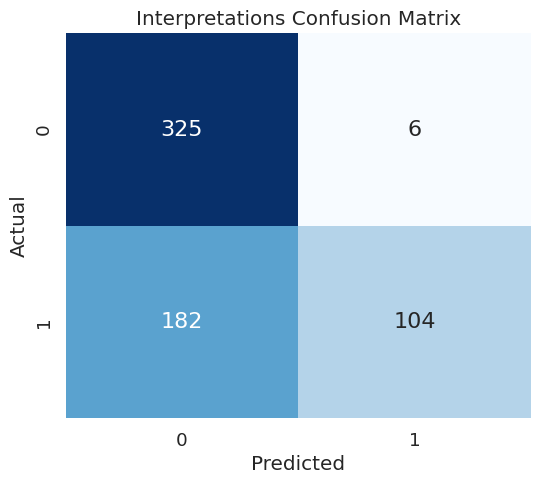

In [ ]:
conf_matrix_in = confusion_matrix(y_in_test, predictions_in)
print(conf_matrix_in)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_in, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Interpretations Confusion Matrix')
plt.show()

# Ex binary prediction (seeker + response)

In [ ]:
y_ex_train, y_ex_val, y_ex_test, X_ex_train, X_ex_val, X_ex_test = get_data('ex')
y_ex_train.value_counts()

1    294
0    282
Name: empathy, dtype: int64

In [ ]:
train_ex_encodings, val_ex_encodings, test_ex_encodings = csv_to_encodings(X_ex_train, X_ex_val, X_ex_test)
train_ex_encodings

{'input_ids': <tf.Tensor: shape=(576, 61), dtype=int32, numpy=
array([[ 101,  146, 3668, ...,    0,    0,    0],
       [ 101, 1302, 1274, ...,    0,    0,    0],
       [ 101, 7595,  117, ...,    0,    0,    0],
       ...,
       [ 101, 1132, 1128, ...,    0,    0,    0],
       [ 101, 1135, 1281, ...,    0,    0,    0],
       [ 101, 8790, 1910, ..., 3737, 1106,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(576, 61), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(576, 61), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [ ]:
ex_classification = create_bert_binary_model(bert_model=bert_model)
ex_classification_history = ex_classification.fit([train_ex_encodings.input_ids, train_ex_encodings.token_type_ids, train_ex_encodings.attention_mask],
                                                  y_ex_train,
                                                  validation_data=([val_ex_encodings.input_ids, val_ex_encodings.token_type_ids, val_ex_encodings.attention_mask],
                                                  y_ex_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
72/72 [==============================] - 14s 81ms/step - loss: 0.2360 - accuracy: 0.9358 - val_loss: 1.2808 - val_accuracy: 0.5104
Epoch 2/10
72/72 [==============================] - 4s 49ms/step - loss: 0.0580 - accuracy: 0.9861 - val_loss: 1.7715 - val_accuracy: 0.5052
Epoch 3/10
72/72 [==============================] - 3s 47ms/step - loss: 0.0403 - accuracy: 0.9931 - val_loss: 1.9207 - val_accuracy: 0.5052
Epoch 4/10
72/72 [==============================] - 4s 54ms/step - loss: 0.0275 - accuracy: 0.9948 - val_loss: 2.2791 - val_accuracy: 0.5052
Epoch 5/10
72/72 [==============================] - 4s 54ms/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 1.8513 - val_accuracy: 0.5052
Epoch 6/10
72/72 [==============================] - 4s 51ms/step - loss: 0.0230 - accuracy: 0.9965 - val_loss: 1.8466 - val_accuracy: 0.5156
Epoch 7/10
72/72 [==============================] - 3s 49ms/step - loss: 0.0272 - accuracy: 0.9948 - val_loss: 2.0598 - val_accuracy: 0.5052
Epoch 8/10
7

In [ ]:
predictions_ex = ex_classification.predict([test_ex_encodings.input_ids, test_ex_encodings.token_type_ids, test_ex_encodings.attention_mask])
predictions_ex = (predictions_ex >= 0.5).astype(int)

6/6 [==============================] - 4s 137ms/step


In [ ]:
accuracy_ex = accuracy_score(y_ex_test, predictions_ex)
print(f"accuracy for test: {accuracy_ex}")
recall_ex = recall_score(y_ex_test, predictions_ex)
print(f"recall for test: {recall_ex}")
precision_ex = precision_score(y_ex_test, predictions_ex)
print(f"precision for test: {precision_ex}")
f1_ex = f1_score(y_ex_test, predictions_ex)
print(f"f1 score for test: {f1_ex}")

accuracy for test: 0.546875
recall for test: 0.04395604395604396
precision for test: 1.0
f1 score for test: 0.08421052631578947


[[101   0]
 [ 87   4]]


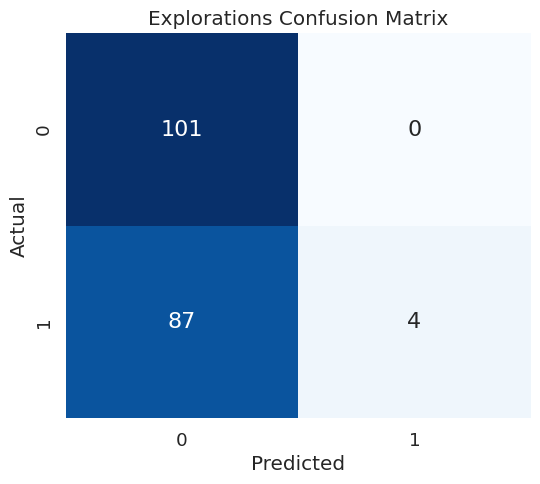

In [ ]:
conf_matrix_ex = confusion_matrix(y_ex_test, predictions_ex)
print(conf_matrix_ex)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ex, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Explorations Confusion Matrix')
plt.show()

# summary

In [ ]:
metrics = {
    'Category': ['em', 'in', 'ex'],
    'Accuracy': [accuracy_em, accuracy_in, accuracy_ex],
    'Precision': [precision_em, precision_in, precision_ex],
    'Recall': [recall_em, recall_in, recall_ex],
    'F1 Score': [f1_em, f1_in, f1_ex]
}

metrics_df = pd.DataFrame(metrics)

metrics_df

,Category,Accuracy,Precision,Recall,F1 Score
0,em,0.632458,0.960784,0.243781,0.388889
1,in,0.695300,0.945455,0.363636,0.525253
2,ex,0.546875,1.000000,0.043956,0.084211
